### Preliminaries

In [2]:
import time
from operator import itemgetter

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
pip install ray


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Prepare dataset


In [5]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=201
)
X.head(n=5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
NUM_MODELS = 12  

In [7]:
# Hyperparameters for GradientBoostingRegressor experiments
GB_PARAMS = {
    "learning_rate": 0.08,
    "max_depth": 4,
    "max_features": 0.8,
    "subsample": 0.9,
}
GB_N_ESTIMATORS_BASE = 40
GB_N_ESTIMATORS_STEP = 20  


In [8]:
def train_and_score_model(
    train_set: pd.DataFrame,
    test_set: pd.DataFrame,
    train_labels: pd.Series,
    test_labels: pd.Series,
    n_estimators: int,
) -> tuple[int, float]:
    start_time = time.time()  

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        random_state=201,
        **GB_PARAMS,
    )
    model.fit(train_set, train_labels)
    y_pred = model.predict(test_set)
    score = mean_squared_error(test_labels, y_pred)

    time_delta = time.time() - start_time
    print(
        "n_estimators=%s, mse=%.4f, took: %.2f seconds | max_depth=%s, max_features=%s"
        % (n_estimators, score, time_delta, GB_PARAMS["max_depth"], GB_PARAMS["max_features"])
    )

    return n_estimators, score

In [9]:
def run_sequential(n_models: int) -> list[tuple[int, float]]:
    return [
        train_and_score_model(
            train_set=X_train,
            test_set=X_test,
            train_labels=y_train,
            test_labels=y_test,
            n_estimators=GB_N_ESTIMATORS_BASE + GB_N_ESTIMATORS_STEP * j,
        )
        for j in range(n_models)
    ]

This function trains `n_models` sequentially for an increasing number of `n_estimators` (starting at 40 and jumping by 20 for each model, e.g. 40, 60, 80, ...). These wider jumps come from the updated Gradient Boosting hyperparameters.

`run_sequential` returns a list of tuples:

`[(n_estimators, mse_score), (n_estimators, mse_score), ...]`
For example:

`[(40, 0.27xx), (60, 0.26xx), (80, 0.25xx)]`

In [11]:
start = time.perf_counter()
gb_sequential_scores = run_sequential(n_models=NUM_MODELS)
sequential_runtime = time.perf_counter() - start
print(f"Sequential gradient boosting runtime: {sequential_runtime:.2f} seconds")

n_estimators=40, mse=0.3448, took: 1.01 seconds | max_depth=4, max_features=0.8
n_estimators=60, mse=0.3070, took: 1.78 seconds | max_depth=4, max_features=0.8
n_estimators=80, mse=0.2860, took: 2.01 seconds | max_depth=4, max_features=0.8
n_estimators=100, mse=0.2743, took: 2.46 seconds | max_depth=4, max_features=0.8
n_estimators=120, mse=0.2666, took: 3.03 seconds | max_depth=4, max_features=0.8
n_estimators=140, mse=0.2597, took: 3.49 seconds | max_depth=4, max_features=0.8
n_estimators=160, mse=0.2540, took: 4.01 seconds | max_depth=4, max_features=0.8
n_estimators=180, mse=0.2497, took: 4.52 seconds | max_depth=4, max_features=0.8
n_estimators=200, mse=0.2433, took: 4.96 seconds | max_depth=4, max_features=0.8
n_estimators=220, mse=0.2405, took: 5.60 seconds | max_depth=4, max_features=0.8
n_estimators=240, mse=0.2378, took: 6.03 seconds | max_depth=4, max_features=0.8
n_estimators=260, mse=0.2357, took: 6.62 seconds | max_depth=4, max_features=0.8
Sequential gradient boosting ru

Results

In [13]:
best = min(gb_sequential_scores, key=itemgetter(1))
print(
    "Best sequential GB model: mse=%.4f, n_estimators=%s" % (best[1], best[0])
)

Best sequential GB model: mse=0.2357, n_estimators=260


### Parallel implementation

In [16]:
import ray

if ray.is_initialized:
    ray.shutdown()

ray.init()# !pip install ray

2025-11-17 23:25:16,866	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-17 23:25:20,340	INFO worker.py:2012 -- Started a local Ray instance.
/opt/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Python version:,3.12.4
Ray version:,2.51.1


In [20]:
X_train_ref = ray.put(X_train)
X_test_ref = ray.put(X_test)
y_train_ref = ray.put(y_train)
y_test_ref = ray.put(y_test)

In [22]:
### SAMPLE IMPLEMENTATION ###

# print the object reference
print(X_train_ref)

# inspect the in-memory object
ray.get(X_train_ref)

ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
19262,3.8750,20.0,5.838000,1.016000,1711.0,3.422000,38.44,-122.73
4083,4.3036,36.0,5.065630,1.069085,1115.0,1.925734,34.15,-118.38
19500,3.1857,24.0,4.902494,1.040816,1468.0,3.328798,37.67,-121.03
9062,3.2500,32.0,5.220884,0.939759,712.0,2.859438,34.69,-118.15
1196,2.6607,22.0,6.508021,1.197861,537.0,2.871658,39.34,-121.67
...,...,...,...,...,...,...,...,...
9082,4.1667,12.0,6.741713,1.109116,2188.0,3.022099,34.69,-118.17
1891,3.3295,17.0,6.144444,1.150000,466.0,2.588889,38.92,-120.00
501,2.2841,52.0,4.350649,1.077922,152.0,1.974026,37.85,-122.27
7680,4.0774,35.0,5.225389,0.992228,1388.0,3.595855,33.92,-118.10


### Implement function to train and score model

In [36]:
@ray.remote
def train_and_score_model(
    train_set_ref: pd.DataFrame,
    test_set_ref: pd.DataFrame,
    train_labels_ref: pd.Series,
    test_labels_ref: pd.Series,
    n_estimators: int,
) -> tuple[int, float]:
    start_time = time.time()  # measure wall time for single model training

    train_set_np = train_set_ref.to_numpy(copy=True)
    test_set_np = test_set_ref.to_numpy(copy=True)
    train_labels_np = train_labels_ref.to_numpy(copy=True)
    test_labels_np = test_labels_ref.to_numpy(copy=True)

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        random_state=201,
        **GB_PARAMS,
    )
    model.fit(train_set_np, train_labels_np)
    y_pred = model.predict(test_set_np)
    score = mean_squared_error(test_labels_np, y_pred)

    time_delta = time.time() - start_time
    print(
        "[Ray] n_estimators=%s, mse=%.4f, took: %.2f seconds"
        % (n_estimators, score, time_delta)
    )

    return n_estimators, score


Implement function that runs parallel model training

In [39]:
def run_parallel(n_models: int) -> list[tuple[int, float]]:
    results_ref = [
        train_and_score_model.remote(
            train_set_ref=X_train_ref,
            test_set_ref=X_test_ref,
            train_labels_ref=y_train_ref,
            test_labels_ref=y_test_ref,
            n_estimators=GB_N_ESTIMATORS_BASE + GB_N_ESTIMATORS_STEP * j,
        )
        for j in range(n_models)
    ]
    return ray.get(results_ref)

### Run parallel model training

In [43]:
start = time.perf_counter()
gb_parallel_scores = run_parallel(n_models=NUM_MODELS)
parallel_runtime = time.perf_counter() - start
print(
    f"Ray parallel gradient boosting runtime: {parallel_runtime:.2f} seconds"
)

(train_and_score_model pid=34528) [Ray] n_estimators=40, mse=0.3448, took: 1.63 seconds
(train_and_score_model pid=34528) [Ray] n_estimators=200, mse=0.2433, took: 6.35 seconds [repeated 8x across cluster]
Ray parallel gradient boosting runtime: 11.49 seconds


In [46]:
best_parallel = min(gb_parallel_scores, key=itemgetter(1))
print(
    "Best Ray GB model: mse=%.4f, n_estimators=%s"
    % (best_parallel[1], best_parallel[0])
)

Best Ray GB model: mse=0.2357, n_estimators=260


In [48]:
comparison_df = pd.DataFrame(
    {
        "mode": ["Sequential", "Ray parallel"],
        "runtime_sec": [sequential_runtime, parallel_runtime],
    }
)
comparison_df["speedup_vs_seq"] = comparison_df.loc[0, "runtime_sec"] / comparison_df["runtime_sec"]
comparison_df


,mode,runtime_sec,speedup_vs_seq
0,Sequential,45.554697,1.000000
1,Ray parallel,11.487673,3.965529


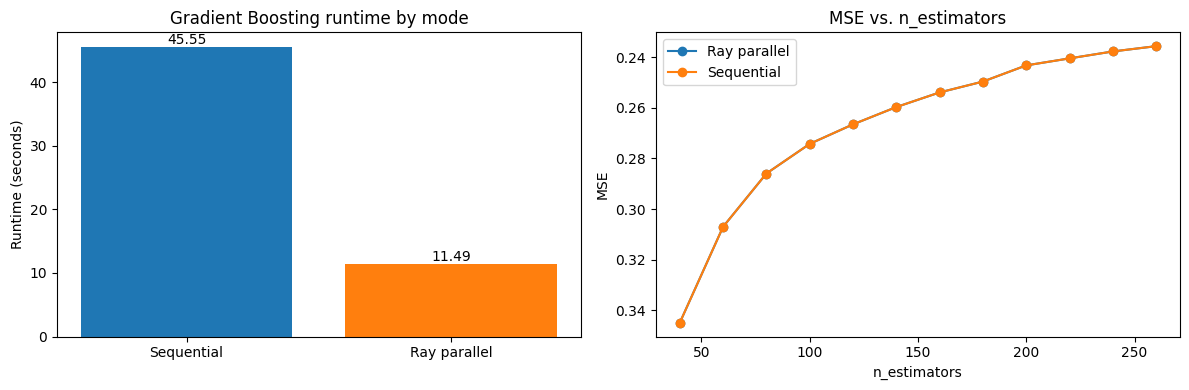

,n_estimators,mse,mode
0,40,0.344837,Ray parallel
1,60,0.306969,Ray parallel
2,80,0.285957,Ray parallel
3,100,0.274263,Ray parallel
4,120,0.266560,Ray parallel


In [50]:
gb_seq_df = pd.DataFrame(gb_sequential_scores, columns=["n_estimators", "mse"]).assign(
    mode="Sequential"
)
gb_par_df = pd.DataFrame(gb_parallel_scores, columns=["n_estimators", "mse"]).assign(
    mode="Ray parallel"
)
gb_all_df = (
    pd.concat([gb_seq_df, gb_par_df], ignore_index=True)
    .sort_values(["mode", "n_estimators"])
    .reset_index(drop=True)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(comparison_df["mode"], comparison_df["runtime_sec"], color=["#1f77b4", "#ff7f0e"])
axes[0].set_ylabel("Runtime (seconds)")
axes[0].set_title("Gradient Boosting runtime by mode")
axes[0].bar_label(axes[0].containers[0], fmt="%.2f")

for mode, group in gb_all_df.groupby("mode"):
    axes[1].plot(
        group["n_estimators"],
        group["mse"],
        marker="o",
        linestyle="-",
        label=mode,
    )
axes[1].set_xlabel("n_estimators")
axes[1].set_ylabel("MSE")
axes[1].set_title("MSE vs. n_estimators")
axes[1].legend()
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

gb_all_df.head()


In [52]:
speedup = comparison_df.loc[1, "speedup_vs_seq"]
print(
    "Sequential runtime: %.2fs | Ray runtime: %.2fs | Speedup: %.2fx"
    % (sequential_runtime, parallel_runtime, speedup)
)
print(
    "Best sequential MSE: %.4f | Best Ray MSE: %.4f"
    % (best[1], best_parallel[1])
)


Sequential runtime: 45.55s | Ray runtime: 11.49s | Speedup: 3.97x
Best sequential MSE: 0.2357 | Best Ray MSE: 0.2357


!pip install py-spy
!sudo chown root:root `which py-spy`
!sudo chmod u+s `which py-spy

In [55]:
# Shutdown Ray runtime
ray.shutdown()

### Summary

- **Setup:** Trained GradientBoostingRegressor on the California Housing dataset with `learning_rate=0.08`, `max_depth=4`, `max_features=0.8`, `subsample=0.9`, and `n_estimators` ranging from 40 to 260 in steps of 20.
- **Sequential vs. Ray:** Sequential pass took ≈45.55 s, while Ray-parallel execution finished in ≈11.49 s—a ~3.97× speedup by distributing each model fit across cores.
- **Model quality:** Both runs reached similar accuracy (best MSE ≈0.236), showing that parallelizing preserved performance.
- **Visualization:** Runtime bar chart and MSE-vs-estimators line plot document the latency gap and the accuracy curve across configurations.

These results confirm the distributed pipeline trains faster without sacrificing error.